In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor

from warnings import filterwarnings
filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/flight-price-prediction/business.csv
/kaggle/input/flight-price-prediction/economy.csv
/kaggle/input/flight-price-prediction/Clean_Dataset.csv


In [2]:
# data preprocessing steps
price = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df = price.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
# flight column dropped because of it not avaible for one hot encoding,
# arrival_time and destination_city column are same as departure_time and source_city
df = df.drop(['flight','arrival_time', 'destination_city'], axis=1)
dms = pd.get_dummies(df[['airline', 'source_city', 'departure_time', 'stops', 'class']])
dms = dms.drop(['class_Business'], axis=1) # to prevent dummy variable trap (class_economy)
y = df['price']
X_ = df.drop(['price', 'airline', 'source_city', 'departure_time', 'stops', 'class'], axis=1)
X = pd.concat([X_, dms], axis=1)

X = X.iloc[0:100] # for test use
y = y.iloc[0:100] # for test use

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [3]:
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (100, 24)
y shape: (100,)


# KNN
## Model

In [4]:
# model training with train data
knn_model = KNeighborsRegressor().fit(X_train, y_train)
knn_model

KNeighborsRegressor()

In [5]:
# to see what is n_neighbors value after training with train data (before tuning)
knn_model.n_neighbors

5

In [6]:
# while detecting n_neighbors values using which metod
knn_model.effective_metric_

'euclidean'

# KNN
## Prediction

In [7]:
# prediction with 'test data'
y_pred = knn_model.predict(X_test)

In [8]:
# to see the rmse value
np.sqrt(mean_squared_error(y_test, y_pred))

3008.1338823928695

# KNN
## Model Tuning

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
knn_params = {'n_neighbors': np.arange(1,30,1)}
knn_params

{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])}

In [11]:
knn = KNeighborsRegressor()
knn

KNeighborsRegressor()

In [12]:
knn_cv_model = GridSearchCV(knn, knn_params, cv=10)

In [13]:
knn_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [14]:
knn_cv_model.best_params_['n_neighbors']

1

In [15]:
knn_tuned = KNeighborsRegressor(n_neighbors = knn_cv_model.best_params_['n_neighbors'])

In [16]:
knn_tuned.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=1)

In [17]:
y_pred = knn_tuned.predict(X_test)

In [18]:
np.sqrt(mean_squared_error(y_test, y_pred))

3810.3793144515153

# SVR (Support Vector Regression) - Linear
## Model

In [19]:
# data preprocessing steps
price = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df = price.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
# flight column dropped because of it not avaible for one hot encoding,
# arrival_time and destination_city column are same as departure_time and source_city
df = df.drop(['flight','arrival_time', 'destination_city'], axis=1)
dms = pd.get_dummies(df[['airline', 'source_city', 'departure_time', 'stops', 'class']])
dms = dms.drop(['class_Business'], axis=1) # to prevent dummy variable trap (class_economy)
y = df['price']
X_ = df.drop(['price', 'airline', 'source_city', 'departure_time', 'stops', 'class'], axis=1)
X = pd.concat([X_, dms], axis=1)
X = X.iloc[0:100]
y = y.iloc[0:100]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [20]:
X_train = pd.DataFrame(X_train["days_left"])
X_test = pd.DataFrame(X_test["days_left"])

In [21]:
from sklearn.svm import LinearSVR

In [22]:
svr_model = LinearSVR(C=0.1).fit(X_train, y_train)

In [23]:
svr_model.predict(X_train)[0:5]

array([15., 15., 15., 15., 15.])

In [24]:
print ("y = {0} + {1} x".format(svr_model.intercept_, 
                                svr_model.coef_))

y = [7.5] + [7.5] x


In [25]:
X_train["days_left"][0:1]

15    1
Name: days_left, dtype: int64

In [26]:
y_pred = svr_model.predict(X_train)

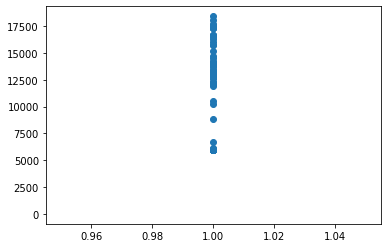

In [27]:
plt.scatter(X_train, y_train)
plt.plot(X_train,y_pred, color = "r")

In [28]:
from sklearn.linear_model import LinearRegression
lm_model = LinearRegression().fit(X_train, y_train)
lm_pred  = lm_model.predict(X_train)
print("y = {0} + {1} x".format(lm_model.intercept_, lm_model.coef_[0]))

y = 12079.146666666667 + 0.0 x


Text(0, 0.5, 'Price')

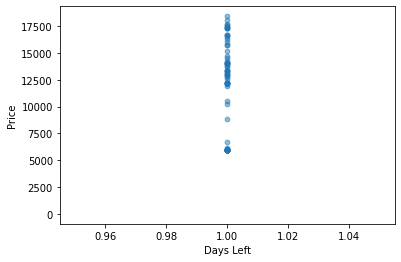

In [29]:
plt.scatter(X_train, y_train, alpha=0.5, s=23)
plt.plot(X_train, lm_pred, 'g')
plt.plot(X_train, y_pred, color='r')

plt.xlabel("Days Left")
plt.ylabel("Price")

## Prediction

In [30]:
y_pred = svr_model.predict(X_test)

In [31]:
np.sqrt(mean_squared_error(y_test, y_pred))

12381.272957172054

## Model Tuning

In [32]:
svr_params = {"C": np.arange(0.1,2,0.1)}
svr_params

{'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
        1.4, 1.5, 1.6, 1.7, 1.8, 1.9])}

In [33]:
svr_cv_model = GridSearchCV(svr_model, svr_params, cv = 10).fit(X_train,y_train)

In [34]:
pd.Series(svr_cv_model.best_params_)

C    1.9
dtype: float64

In [35]:
pd.Series(svr_cv_model.best_params_)[0]

1.9000000000000001

In [36]:
svr_tuned = LinearSVR( 
                C = pd.Series(svr_cv_model.best_params_)[0]).fit(X_train, y_train)

In [37]:
y_pred = svr_tuned.predict(X_test)

In [38]:
np.sqrt(mean_squared_error(y_test, y_pred))

12125.908858308312

# Non-Linear SVR (Support Vector Regression)

## Model

In [39]:
# data preprocessing steps
price = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df = price.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
# flight column dropped because of it not avaible for one hot encoding,
# arrival_time and destination_city column are same as departure_time and source_city
df = df.drop(['flight','arrival_time', 'destination_city'], axis=1)
dms = pd.get_dummies(df[['airline', 'source_city', 'departure_time', 'stops', 'class']])
dms = dms.drop(['class_Business'], axis=1) # to prevent dummy variable trap (class_economy)
y = df['price']
X_ = df.drop(['price', 'airline', 'source_city', 'departure_time', 'stops', 'class'], axis=1)
X = pd.concat([X_, dms], axis=1)
X = X.iloc[0:100]
y = y.iloc[0:100]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [40]:
from sklearn.svm import SVR

In [41]:
svr_rbf = SVR(epsilon=0.1).fit(X_train, y_train)

## Prediction

In [42]:
y_pred = svr_rbf.predict(X_test)

In [43]:
np.sqrt(mean_squared_error(y_test, y_pred))

4166.735630882699

## Model Tuning

In [44]:
svr_rbf

SVR()

In [45]:
svr_params = {"C": [0.01, 0.1,0.4,5,10,20,30,40,50]}
svr_cv_model = GridSearchCV(svr_rbf,svr_params, cv = 10)
svr_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 0.4, 5, 10, 20, 30, 40, 50]})

In [46]:
pd.Series(svr_cv_model.best_params_)[0]

0.01

In [47]:
svr_tuned = SVR( C = pd.Series(svr_cv_model.best_params_)[0]).fit(X_train, y_train)

In [48]:
y_pred = svr_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

4171.223132809598

# Multi-Layer Perceptron

## Model

In [49]:
# data preprocessing steps
price = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df = price.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
# flight column dropped because of it not avaible for one hot encoding,
# arrival_time and destination_city column are same as departure_time and source_city
df = df.drop(['flight','arrival_time', 'destination_city'], axis=1)
dms = pd.get_dummies(df[['airline', 'source_city', 'departure_time', 'stops', 'class']])
dms = dms.drop(['class_Business'], axis=1) # to prevent dummy variable trap (class_economy)
y = df['price']
X_ = df.drop(['price', 'airline', 'source_city', 'departure_time', 'stops', 'class'], axis=1)
X = pd.concat([X_, dms], axis=1)
X = X.iloc[0:100]
y = y.iloc[0:100]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [52]:
X_train_scaled = scaler.transform(X_train)

In [53]:
X_test_scaled = scaler.transform(X_test)

In [54]:
X_train.head()

,duration,days_left,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Bangalore,source_city_Chennai,...,departure_time_Afternoon,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,stops_one,stops_two_or_more,stops_zero,class_Economy
15,2.33,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
40,11.00,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
96,23.83,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
9,2.25,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
72,7.08,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1


In [55]:
X_train_scaled[0:5,:]

array([[-1.1059183 ,  0.        , -0.23735633, -0.60302269, -0.32084447,
         2.29128785, -0.20412415, -0.79399923,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.54139029,
        -0.47907014, -0.66506217,  0.        ,  2.        , -0.29488391,
        -1.71679015,  0.        ,  1.71679015,  0.        ],
       [-0.16062375,  0.        , -0.23735633,  1.6583124 , -0.32084447,
        -0.43643578, -0.20412415, -0.79399923,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.54139029,
        -0.47907014, -0.66506217,  0.        , -0.5       ,  3.39116499,
         0.58248237,  0.        , -0.58248237,  0.        ],
       [ 1.23823773,  0.        , -0.23735633,  1.6583124 , -0.32084447,
        -0.43643578, -0.20412415, -0.79399923,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.54139029,
        -0.47907014, -0.66506217,  0.        , -0.5       ,  3.39116499,
  

In [56]:
from sklearn.neural_network import MLPRegressor

In [57]:
mlp_model = MLPRegressor(hidden_layer_sizes = (100,20)).fit(X_train_scaled, y_train)
mlp_model

MLPRegressor(hidden_layer_sizes=(100, 20))

In [58]:
mlp_model.n_layers_

4

In [59]:
mlp_model.hidden_layer_sizes

(100, 20)

## Prediction

In [60]:
y_pred = mlp_model.predict(X_test_scaled)

In [61]:
np.sqrt(mean_squared_error(y_test, y_pred))

12217.931004234675

## Model Tunning

In [62]:
mlp_model

MLPRegressor(hidden_layer_sizes=(100, 20))

In [63]:
mlp_params = {'alpha': [0.1, 0.01,0.02,0.005],
             'hidden_layer_sizes': [(20,20),(100,50,150),(300,200,150)],
             'activation': ['relu','logistic']}

In [64]:
mlp_cv_model = GridSearchCV(mlp_model, mlp_params, cv = 10)

In [65]:
mlp_cv_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=MLPRegressor(hidden_layer_sizes=(100, 20)),
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.1, 0.01, 0.02, 0.005],
                         'hidden_layer_sizes': [(20, 20), (100, 50, 150),
                                                (300, 200, 150)]})

In [66]:
mlp_cv_model.best_params_

{'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (300, 200, 150)}

In [67]:
mlp_tuned = MLPRegressor(alpha = mlp_cv_model.best_params_['alpha'], hidden_layer_sizes = mlp_cv_model.best_params_['hidden_layer_sizes'])

In [68]:
mlp_tuned = MLPRegressor(alpha = 0.01, hidden_layer_sizes = (100, 50, 150),activation='relu')

In [69]:
mlp_tuned.fit(X_train_scaled, y_train)

MLPRegressor(alpha=0.01, hidden_layer_sizes=(100, 50, 150))

In [70]:
y_pred = mlp_tuned.predict(X_test_scaled)

In [71]:
np.sqrt(mean_squared_error(y_test, y_pred))

3631.0713157748323

# CART

## Model

In [72]:
# data preprocessing steps
price = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df = price.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
# flight column dropped because of it not avaible for one hot encoding,
# arrival_time and destination_city column are same as departure_time and source_city
df = df.drop(['flight','arrival_time', 'destination_city'], axis=1)
dms = pd.get_dummies(df[['airline', 'source_city', 'departure_time', 'stops', 'class']])
dms = dms.drop(['class_Business'], axis=1) # to prevent dummy variable trap (class_economy)
y = df['price']
X_ = df.drop(['price', 'airline', 'source_city', 'departure_time', 'stops', 'class'], axis=1)
X = pd.concat([X_, dms], axis=1)
X = X.iloc[0:100]
y = y.iloc[0:100]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [73]:
cart_model = DecisionTreeRegressor(min_samples_split = 2)

In [74]:
cart_model.fit(X_train, y_train)

DecisionTreeRegressor()

## Prediction

In [75]:
y_pred =cart_model.predict(X_test)

In [76]:
np.sqrt(mean_squared_error(y_test, y_pred))

2570.2381912966744

## Model Tuning

In [77]:
cart_model = DecisionTreeRegressor()

In [78]:
cart_params = {"min_samples_split": range(2,100),
               "max_leaf_nodes": range(2,10)}

In [79]:
cart_cv_model = GridSearchCV(cart_model, cart_params, cv = 10)

In [80]:
cart_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_leaf_nodes': range(2, 10),
                         'min_samples_split': range(2, 100)})

In [81]:
cart_cv_model.best_params_

{'max_leaf_nodes': 8, 'min_samples_split': 3}

In [82]:
cart_tuned = DecisionTreeRegressor(max_leaf_nodes = cart_cv_model.best_params_['max_leaf_nodes'], min_samples_split = cart_cv_model.best_params_['min_samples_split'])

In [83]:
cart_tuned.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=8, min_samples_split=3)

In [84]:
y_pred = cart_tuned.predict(X_test)

In [85]:
np.sqrt(mean_squared_error(y_test, y_pred))

3176.4512100633933

# Bagged Trees Regresyon

## Model

In [86]:
# data preprocessing steps
price = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df = price.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
# flight column dropped because of it not avaible for one hot encoding,
# arrival_time and destination_city column are same as departure_time and source_city
df = df.drop(['flight','arrival_time', 'destination_city'], axis=1)
dms = pd.get_dummies(df[['airline', 'source_city', 'departure_time', 'stops', 'class']])
dms = dms.drop(['class_Business'], axis=1) # to prevent dummy variable trap (class_economy)
y = df['price']
X_ = df.drop(['price', 'airline', 'source_city', 'departure_time', 'stops', 'class'], axis=1)
X = pd.concat([X_, dms], axis=1)
X = X.iloc[0:100]
y = y.iloc[0:100]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [87]:
bag_model = BaggingRegressor(n_estimators = 8,bootstrap_features = True)
bag_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True, n_estimators=8)

In [88]:
bag_model.n_estimators

8

In [89]:
bag_model.estimators_

[DecisionTreeRegressor(random_state=1889917649),
 DecisionTreeRegressor(random_state=1386910131),
 DecisionTreeRegressor(random_state=1759203400),
 DecisionTreeRegressor(random_state=350151550),
 DecisionTreeRegressor(random_state=686876450),
 DecisionTreeRegressor(random_state=256162418),
 DecisionTreeRegressor(random_state=180185237),
 DecisionTreeRegressor(random_state=250208616)]

## Prediction

In [90]:
y_pred = bag_model.predict(X_test)

In [91]:
np.sqrt(mean_squared_error(y_test, y_pred))

3157.351211384086

In [92]:
iki_y_pred = bag_model.estimators_[1].fit(X_train, y_train).predict(X_test)

In [93]:
np.sqrt(mean_squared_error(y_test, iki_y_pred))

2665.9198412555465

In [94]:
yedi_y_pred = bag_model.estimators_[7].fit(X_train, y_train).predict(X_test)

In [95]:
np.sqrt(mean_squared_error(y_test, yedi_y_pred))

2697.0115535533027

## Model Tuning

In [96]:
bag_params = {"n_estimators": range(2,20)}

In [97]:
bag_cv_model = GridSearchCV(bag_model, bag_params, cv = 10)

In [98]:
bag_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=BaggingRegressor(bootstrap_features=True,
                                        n_estimators=8),
             param_grid={'n_estimators': range(2, 20)})

In [99]:
bag_cv_model.best_params_

{'n_estimators': 17}

In [100]:
bag_tuned = BaggingRegressor( n_estimators = bag_cv_model.best_params_['n_estimators'], random_state = 45)

In [101]:
bag_tuned.fit(X_train, y_train)

BaggingRegressor(n_estimators=17, random_state=45)

In [102]:
y_pred = bag_tuned.predict(X_test)

In [103]:
np.sqrt(mean_squared_error(y_test, y_pred))

2513.98415671143

# Random Forest

## Model

In [104]:
# data preprocessing steps
price = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df = price.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
# flight column dropped because of it not avaible for one hot encoding,
# arrival_time and destination_city column are same as departure_time and source_city
df = df.drop(['flight','arrival_time', 'destination_city'], axis=1)
dms = pd.get_dummies(df[['airline', 'source_city', 'departure_time', 'stops', 'class']])
dms = dms.drop(['class_Business'], axis=1) # to prevent dummy variable trap (class_economy)
y = df['price']
X_ = df.drop(['price', 'airline', 'source_city', 'departure_time', 'stops', 'class'], axis=1)
X = pd.concat([X_, dms], axis=1)
X = X.iloc[0:100]
y = y.iloc[0:100]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [105]:
from sklearn.ensemble import RandomForestRegressor

In [106]:
rf_model = RandomForestRegressor(random_state = 42)

In [107]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Prediction

In [108]:
rf_model.predict(X_test)[0:5]

array([15502.80333333, 13032.07      , 15363.36      , 13978.75      ,
       13980.68      ])

In [109]:
y_pred = rf_model.predict(X_test)

In [110]:
np.sqrt(mean_squared_error(y_test, y_pred))

2448.907600641605

## Model Tuning

In [111]:
rf_params = {'max_depth': list(range(1,10)),
            'max_features': [3,5,10,15],
            'n_estimators' : [100, 200, 500, 1000, 2000]}

In [112]:
rf_model = RandomForestRegressor(random_state = 42)

In [113]:
rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 10, 
                            n_jobs = -1)

In [114]:
rf_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [3, 5, 10, 15],
                         'n_estimators': [100, 200, 500, 1000, 2000]})

In [115]:
rf_cv_model.best_params_

{'max_depth': 8, 'max_features': 3, 'n_estimators': 100}

In [116]:
rf_tuned = RandomForestRegressor(max_depth  = rf_cv_model.best_params_['max_depth'], 
                                max_features = rf_cv_model.best_params_['max_features'], 
                                n_estimators =rf_cv_model.best_params_['n_estimators'])

In [117]:
rf_tuned.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=3)

In [118]:
y_pred = rf_tuned.predict(X_test)

In [119]:
np.sqrt(mean_squared_error(y_test, y_pred))

2603.82838976761

In [120]:
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                         index = X_train.columns)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

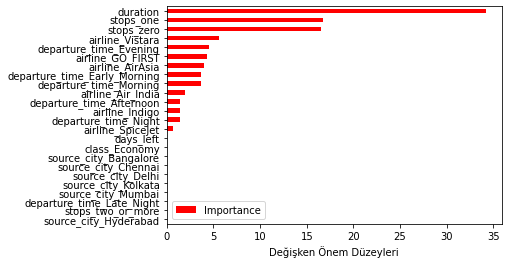

In [121]:
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Değişken Önem Düzeyleri")

# Gradient Boosting Machines

## Model

In [122]:
# data preprocessing steps
price = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df = price.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
# flight column dropped because of it not avaible for one hot encoding,
# arrival_time and destination_city column are same as departure_time and source_city
df = df.drop(['flight','arrival_time', 'destination_city'], axis=1)
dms = pd.get_dummies(df[['airline', 'source_city', 'departure_time', 'stops', 'class']])
dms = dms.drop(['class_Business'], axis=1) # to prevent dummy variable trap (class_economy)
y = df['price']
X_ = df.drop(['price', 'airline', 'source_city', 'departure_time', 'stops', 'class'], axis=1)
X = pd.concat([X_, dms], axis=1)
X = X.iloc[0:100]
y = y.iloc[0:100]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [123]:
from sklearn.ensemble import GradientBoostingRegressor

In [124]:
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)

GradientBoostingRegressor()

## Prediction

In [125]:
y_pred = gbm_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

2561.4298673871517

## Model Tuning

In [126]:
gbm_params = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 5, 8,50,100],
    'n_estimators': [200, 500, 1000, 2000],
    'subsample': [1,0.5,0.75],
}

In [127]:
gbm = GradientBoostingRegressor()
gbm_cv_model = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 0)
gbm_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 8, 50, 100],
                         'n_estimators': [200, 500, 1000, 2000],
                         'subsample': [1, 0.5, 0.75]})

In [128]:
gbm_cv_model.best_params_

{'learning_rate': 0.001,
 'max_depth': 100,
 'n_estimators': 2000,
 'subsample': 0.75}

In [129]:
gbm_tuned = GradientBoostingRegressor(learning_rate = gbm_cv_model.best_params_['learning_rate'],  
                                     max_depth = gbm_cv_model.best_params_['max_depth'], 
                                     n_estimators = gbm_cv_model.best_params_['n_estimators'], 
                                     subsample = gbm_cv_model.best_params_['subsample'])

gbm_tuned = gbm_tuned.fit(X_train,y_train)

In [130]:
gbm_tuned = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 3, n_estimators = 1000, subsample = 0.75)
gbm_tuned = gbm_tuned.fit(X_train,y_train)

In [131]:
y_pred = gbm_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

2698.233508022612

# XGBOOST

## Model

In [132]:
# data preprocessing steps
price = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df = price.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
# flight column dropped because of it not avaible for one hot encoding,
# arrival_time and destination_city column are same as departure_time and source_city
df = df.drop(['flight','arrival_time', 'destination_city'], axis=1)
dms = pd.get_dummies(df[['airline', 'source_city', 'departure_time', 'stops', 'class']])
dms = dms.drop(['class_Business'], axis=1) # to prevent dummy variable trap (class_economy)
y = df['price']
X_ = df.drop(['price', 'airline', 'source_city', 'departure_time', 'stops', 'class'], axis=1)
X = pd.concat([X_, dms], axis=1)
X = X.iloc[0:100]
y = y.iloc[0:100]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [133]:
from xgboost import XGBRegressor

In [134]:
xgb_model = XGBRegressor().fit(X_train, y_train)

## Prediction

In [135]:
y_pred = xgb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

2381.693369751562

## Model Tuning

In [136]:
xgb_grid = {
     'colsample_bytree': [0.4, 0.5,0.6,0.9,1], 
     'n_estimators':[100, 200, 500, 1000],
     'max_depth': [2,3,4,5,6],
     'learning_rate': [0.1, 0.01, 0.5]
}

In [137]:
xgb = XGBRegressor()

xgb_cv = GridSearchCV(xgb, 
                      param_grid = xgb_grid, 
                      cv = 10, 
                      n_jobs = -1,
                      verbose = 0)

In [138]:
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_ca...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [139]:
xgb_cv.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 500}

In [140]:
xgb_tuned = XGBRegressor(colsample_bytree = xgb_cv.best_params_['colsample_bytree'], 
                        learning_rate = xgb_cv.best_params_['learning_rate'], 
                        max_depth = xgb_cv.best_params_['max_depth'], 
                        n_estimators = xgb_cv.best_params_['n_estimators']) 

xgb_tuned = xgb_tuned.fit(X_train,y_train)

In [141]:
y_pred = xgb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

2544.8366058904185

# Light GBM

## Model

In [142]:
# data preprocessing steps
price = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df = price.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
# flight column dropped because of it not avaible for one hot encoding,
# arrival_time and destination_city column are same as departure_time and source_city
df = df.drop(['flight','arrival_time', 'destination_city'], axis=1)
dms = pd.get_dummies(df[['airline', 'source_city', 'departure_time', 'stops', 'class']])
dms = dms.drop(['class_Business'], axis=1) # to prevent dummy variable trap (class_economy)
y = df['price']
X_ = df.drop(['price', 'airline', 'source_city', 'departure_time', 'stops', 'class'], axis=1)
X = pd.concat([X_, dms], axis=1)
X = X.iloc[0:100]
y = y.iloc[0:100]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [143]:
from lightgbm import LGBMRegressor

In [144]:
lgbm = LGBMRegressor(learning_rate = 1, max_depth = 1, colsample_bytree = 1)
lgbm_model = lgbm.fit(X_train, y_train)

## Prediction

In [145]:
y_pred = lgbm_model.predict(X_test, 
                            num_iteration = lgbm_model.best_iteration_)

In [146]:
np.sqrt(mean_squared_error(y_test, y_pred))

2663.1489517041514

## Model Tuning

In [147]:
lgbm_grid = {
    'colsample_bytree': [0.4, 0.5,0.6,0.9,1],
    'learning_rate': [0.01, 0.1, 0.5,1],
    'n_estimators': [20, 40, 100, 200, 500,1000],
    'max_depth': [1,2,3,4,5,6,7,8] }

lgbm = LGBMRegressor()
lgbm_cv_model = GridSearchCV(lgbm, lgbm_grid, cv=10, n_jobs = -1, verbose = 0)

In [148]:
lgbm_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6, 0.9, 1],
                         'learning_rate': [0.01, 0.1, 0.5, 1],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [20, 40, 100, 200, 500, 1000]})

In [149]:
lgbm_cv_model.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 1,
 'max_depth': 1,
 'n_estimators': 20}

In [150]:
lgbm_tuned = LGBMRegressor(learning_rate = lgbm_cv_model.best_params_['learning_rate'], 
                          max_depth = lgbm_cv_model.best_params_['max_depth'], 
                          n_estimators = lgbm_cv_model.best_params_['n_estimators'],
                         colsample_bytree = lgbm_cv_model.best_params_['colsample_bytree'])

lgbm_tuned = lgbm_tuned.fit(X_train,y_train)

In [151]:
lgbm_tuned = LGBMRegressor(learning_rate = 0.1, max_depth = 6, n_estimators = 20, colsample_bytree = 0.5)
lgbm_tuned = lgbm_tuned.fit(X_train,y_train)

In [152]:
y_pred = lgbm_tuned.predict(X_test)

In [153]:
np.sqrt(mean_squared_error(y_test, y_pred))

2934.2722246637545

# CatBoost

## Model

In [154]:
# data preprocessing steps
price = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df = price.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
# flight column dropped because of it not avaible for one hot encoding,
# arrival_time and destination_city column are same as departure_time and source_city
df = df.drop(['flight','arrival_time', 'destination_city'], axis=1)
dms = pd.get_dummies(df[['airline', 'source_city', 'departure_time', 'stops', 'class']])
dms = dms.drop(['class_Business'], axis=1) # to prevent dummy variable trap (class_economy)
y = df['price']
X_ = df.drop(['price', 'airline', 'source_city', 'departure_time', 'stops', 'class'], axis=1)
X = pd.concat([X_, dms], axis=1)
X = X.iloc[0:100]
y = y.iloc[0:100]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [155]:
from catboost import CatBoostRegressor

In [156]:
catb = CatBoostRegressor(learning_rate = 0.01, depth = 1, verbose=0)
catb_model = catb.fit(X_train, y_train)

## Prediction

In [157]:
y_pred = catb_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

2780.1712888602397

## Model Tuning

In [158]:
catb_grid = {
    'iterations': [200,500,1000,2000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [3,4,5,6,7,8] }

In [159]:
catb = CatBoostRegressor()
catb_cv_model = GridSearchCV(catb, catb_grid, cv=3, n_jobs = -1, verbose = 0)
catb_cv_model.fit(X_train, y_train)

In [ ]:
catb_cv_model.best_params_

In [ ]:
catb_tuned = CatBoostRegressor(iterations = catb_cv_model.best_params_['iterations'], 
                              learning_rate = catb_cv_model.best_params_['learning_rate'], 
                              depth = catb_cv_model.best_params_['depth'], verbose=0)

In [ ]:
catb_tuned = catb_tuned.fit(X_train,y_train)

In [ ]:
y_pred = catb_tuned.predict(X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

# Results



